In [1]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 
import scipy
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from gibbsrank import gibbs_sample
from eprank import eprank
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(14,8.27)})
sns.set_palette('colorblind')
from cw2 import sorted_barplot

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [2]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
G = data['G'] - 1
# Number of players
M = W.shape[0]
# Number of Games
N = G.shape[0]

# Gibbs sampling (This may take a minute)

In [3]:
# number of iterations
num_iters = 15000
# perform gibbs sampling, skill samples is an num_players x num_samples array
skill_samples = gibbs_sample(G, M, num_iters)#, random_nums)

100%|██████████| 15000/15000 [15:24<00:00, 16.22it/s]


## A)

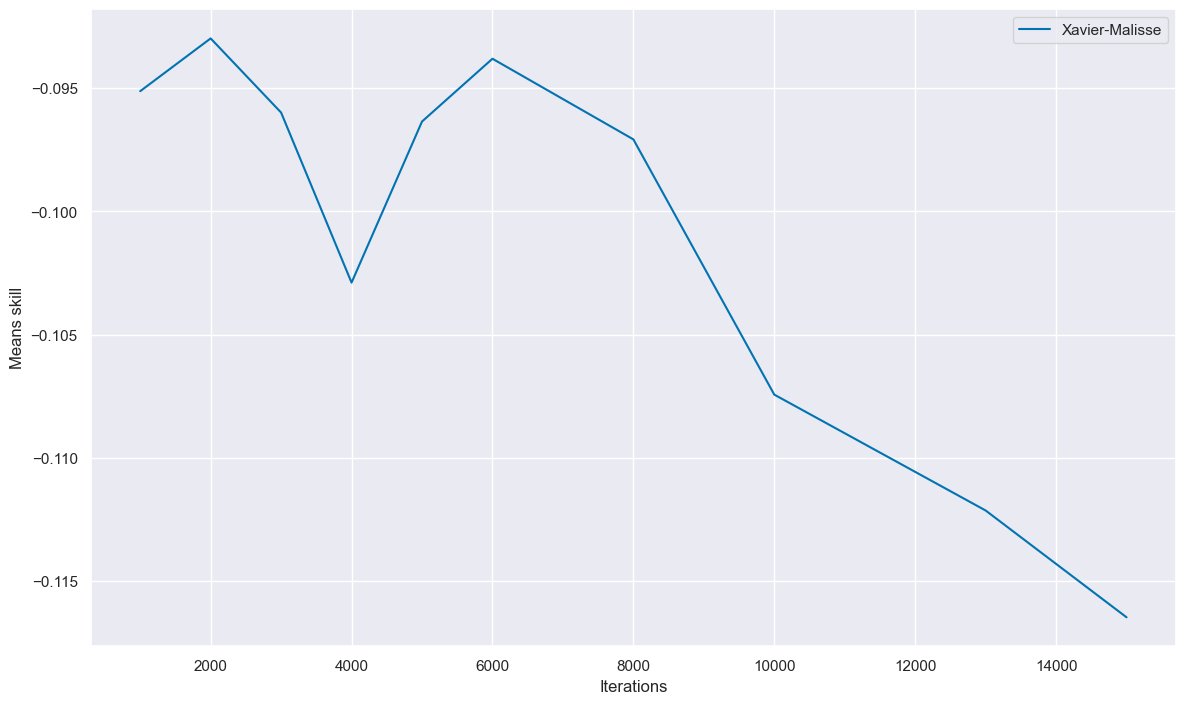

In [4]:
np.random.seed(0)

iterations = [1000, 2000, 3000, 4000, 5000, 6000, 8000, 10000, 13000, 15000]
iter_data = np.zeros((3, len(iterations)))

players = np.random.choice(M, size=3, replace=False)
for i in range(3):
    for index, iter in enumerate(iterations):
        # print(W[players[i],0], skill_samples[players[i], burn:2000].mean())
        iter_data[i, index] = skill_samples[players[i], 50:iter:10].mean()
plt.plot(iterations, iter_data[2, :], label = W[players[2],0])
plt.xlabel('Iterations')
plt.ylabel('Means skill')
plt.legend()
plt.savefig('Figures/Exa_iter.png', format="png", dpi=500, bbox_inches="tight")
plt.show()
plt.close()

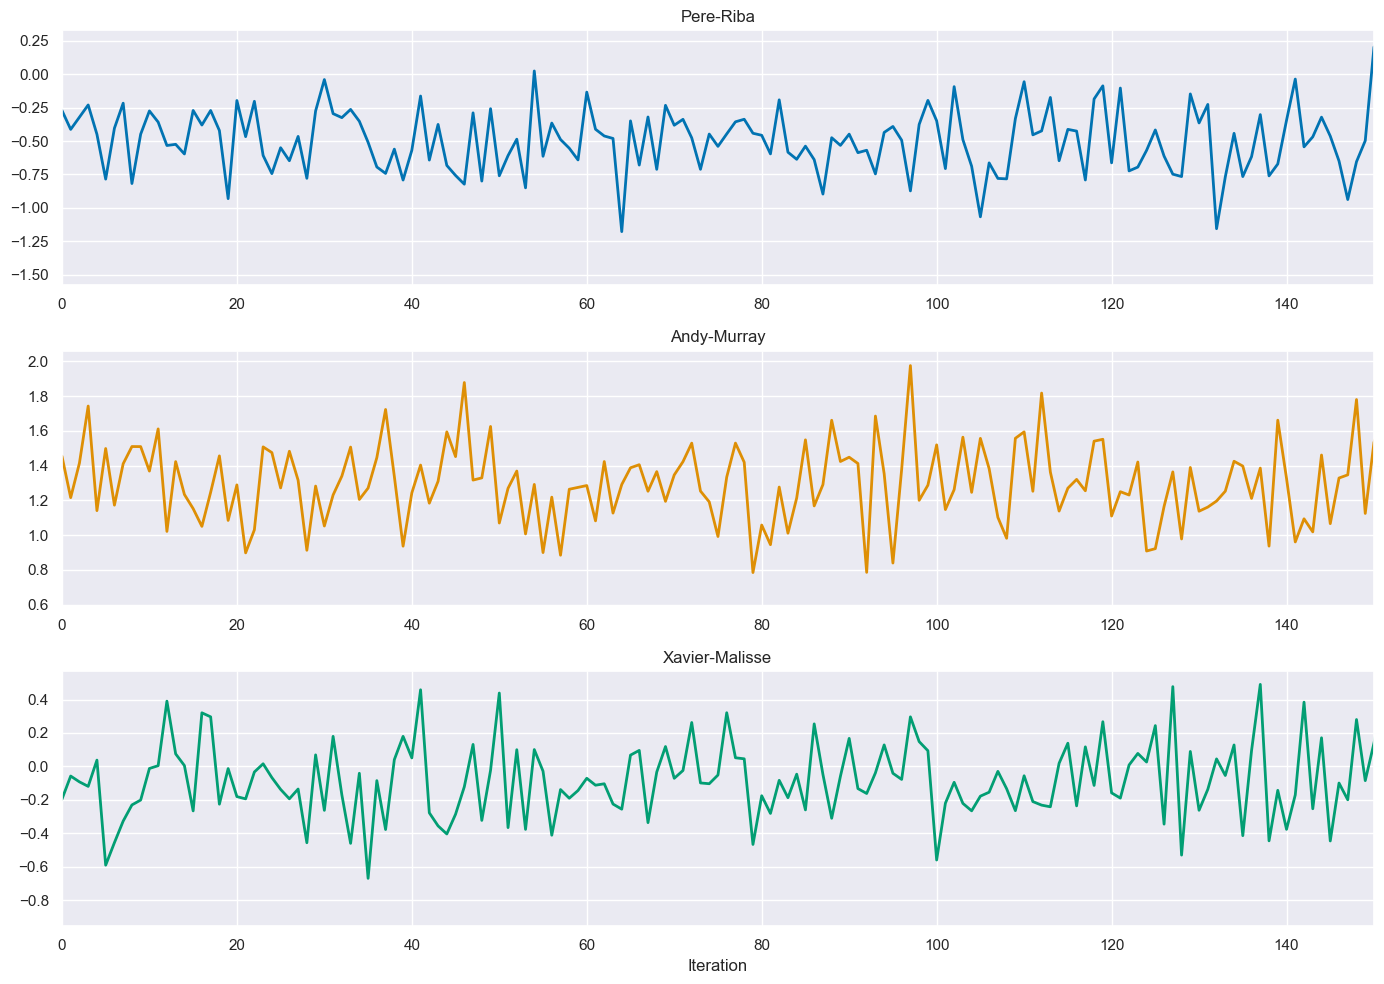

In [5]:
n_players=3
n_steps = 151
np.random.seed(0)

fig, axes = plt.subplots(n_players,figsize=(14,10), tight_layout=True)
players = np.random.choice(M, size=n_players, replace=False)
for i in range(n_players):
    axes[i].plot(skill_samples[players[i], 50:15000:10].T, label=W[i, 0], linewidth=2.0, color=sns.color_palette('colorblind', 4)[i])
    axes[i].set_xlim(0, n_steps-1)
    axes[i].set_title(W[players[i],0])
plt.xlabel('Iteration')
plt.savefig('Figures/Exa_gibbssampling_comp.png', format="png", dpi=500, bbox_inches="tight")
plt.show()
plt.close()

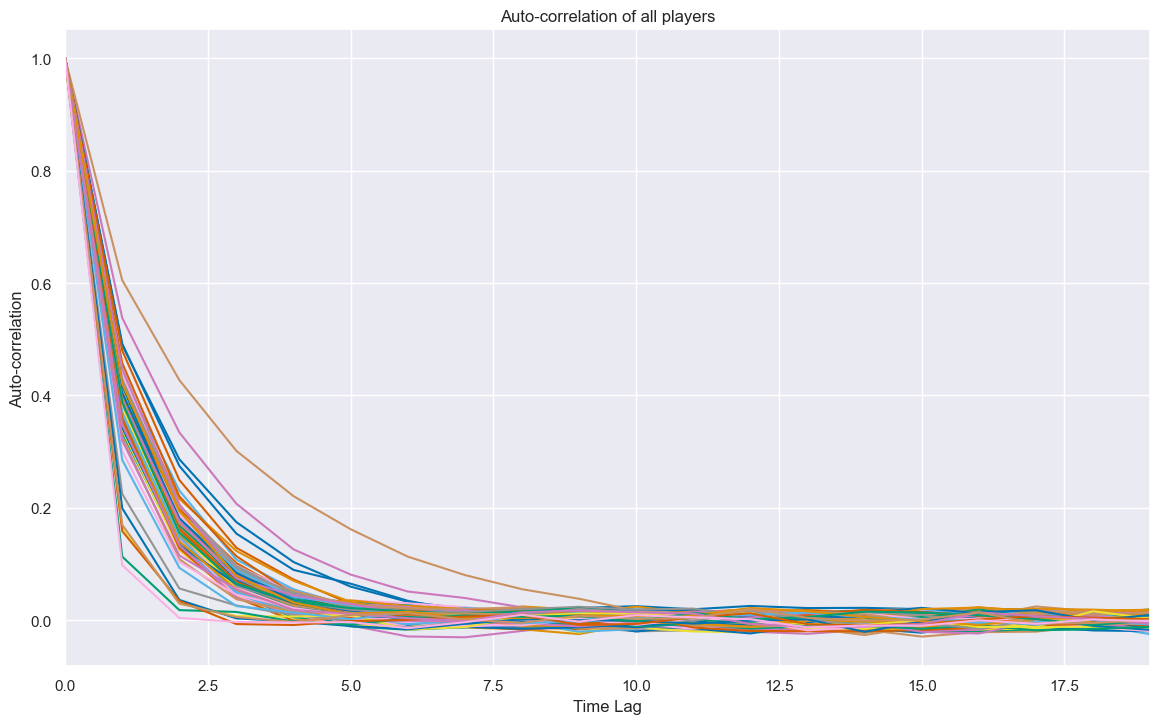

In [6]:
# Code for plotting the autocorrelation function for player p
player = 0
n_steps = 20

for index,name in enumerate(W):
    autocor = np.zeros(n_steps)
    for i in range(n_steps):
        autocor[i]=pd.Series.autocorr(pd.Series(skill_samples[index,:]),lag=i)
    plt.plot(autocor)
plt.title(f'Auto-correlation of all players')
plt.xlabel('Time Lag');
plt.ylabel('Auto-correlation')
plt.xlim(0, n_steps - 1)
plt.savefig('Figures/Exa_auto.png', format="png", dpi=500, bbox_inches="tight")
plt.show()
plt.close()

# EP ranking

## B)

In [7]:
 num_iter_sequence = 35

iterations = (np.indices((num_iter_sequence,)) + 1)**2
mean_player_skills, precision_player_skills = np.zeros((107, num_iter_sequence)), np.zeros((107, num_iter_sequence))
for index, num_iterations in enumerate(iterations[0]):
    mean_player_skills[:, index], precision_player_skills[:, index] = eprank(G, M, num_iterations)

In [8]:
print(iterations)

[[   1    4    9   16   25   36   49   64   81  100  121  144  169  196
   225  256  289  324  361  400  441  484  529  576  625  676  729  784
   841  900  961 1024 1089 1156 1225]]


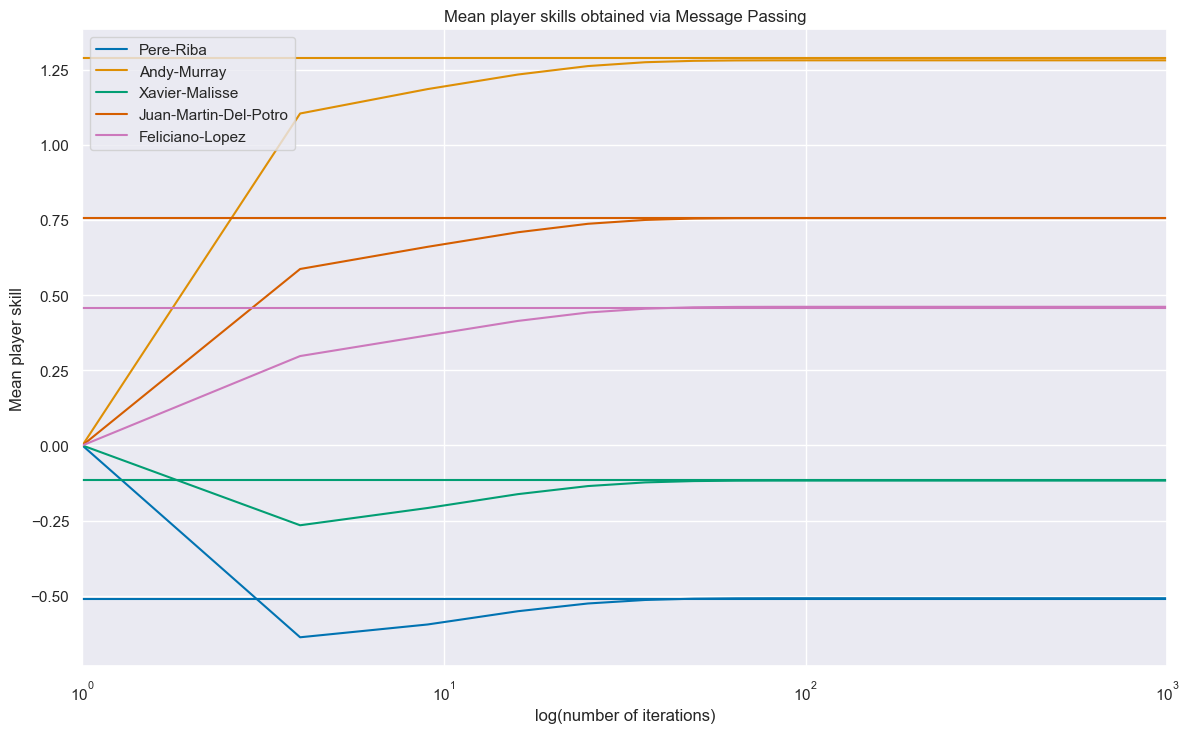

In [9]:
n_players=5

np.random.seed(0)
players = np.random.choice(M, size=n_players, replace=False)

for index, i in enumerate(players):
    plt.plot(iterations.T, mean_player_skills[i, ], color=sns.color_palette('colorblind', n_players)[index])
    plt.axhline(y=skill_samples[i,50:15000:10].mean(), linestyle='-', color=sns.color_palette('colorblind', n_players)[index], label = W[i,0])
    plt.xlim(1, 1000)
    plt.xscale('log')
    plt.title('Mean player skills obtained via Message Passing')
    plt.xlabel('log(number of iterations)')
    plt.ylabel('Mean player skill')
plt.legend()
plt.savefig('Figures/Exb_mp_iter.png', format="png", dpi=500, bbox_inches="tight")
plt.show()
plt.close()

## C)

In [10]:
names = W[[15, 4, 0, 10],]
print(names)
skill = mean_player_skills[[15, 0, 4, 10], 7]
precision = precision_player_skills[[15, 0, 4, 10], 7]

[['Novak-Djokovic']
 ['Roger-Federer']
 ['Rafael-Nadal']
 ['Andy-Murray']]


In [11]:
def skill_win_matrix(number_players, skill, precision):
    skill_prob = np.zeros((number_players, number_players))
    win_prob = np.zeros((number_players, number_players))
    for row in range(number_players):
        for column in range(number_players):
            if row != column:
                variance_sum = precision[row]**-1 + precision[column]**-1
                skill_prob[row, column] = scipy.stats.norm.cdf(0, skill[row]-skill[column], variance_sum**0.5)
                win_prob[row, column] = scipy.stats.norm.cdf(0, skill[row]-skill[column], (1+variance_sum)**0.5)
            else:
                skill_prob[row, column], win_prob[row, column] = 0, 0
    return skill_prob, win_prob

In [12]:
def get_win_skill_prob(mean_player_skills, precision_player_skills, W, player_ids=None):
    if player_ids is not None:
        number_players = len(player_ids)
        names = W[player_ids,]
        skill = mean_player_skills[player_ids, 7]
        precision = precision_player_skills[player_ids, 7]
    else:
        number_players = W.shape[0]
        names = W
        skill = mean_player_skills[:, 7]
        precision = precision_player_skills[:, 7]
    skill_prob, win_prob = skill_win_matrix(number_players, skill, precision)
    return skill_prob, win_prob, names

In [13]:
skill_prob, win_prob, names = get_win_skill_prob(mean_player_skills, precision_player_skills, W, player_ids=[15, 4, 0, 10])

In [14]:
skill_prob

array([[0.        , 0.09111384, 0.06017536, 0.01467879],
       [0.90888616, 0.        , 0.42716413, 0.18916812],
       [0.93982464, 0.57283587, 0.        , 0.23349016],
       [0.98532121, 0.81083188, 0.76650984, 0.        ]])

In [15]:
win_prob

array([[0.        , 0.36197299, 0.34463157, 0.28017566],
       [0.63802701, 0.        , 0.48164664, 0.40912258],
       [0.65536843, 0.51835336, 0.        , 0.42689314],
       [0.71982434, 0.59087742, 0.57310686, 0.        ]])

# D) Nadal and Djokovic skill comparison

In [16]:
names = W[[15, 0],]
print(names)

[['Novak-Djokovic']
 ['Rafael-Nadal']]


In [17]:
Djok = skill_samples[15, 50:15000:10]
Nadal = skill_samples[0, 50:15000:10]

## 1) based on approximating their marginal skills by Gaussians

In [18]:
Djok_mean, Djok_var = Djok.mean(), Djok.var()
Nadal_mean, Nadal_var = Nadal.mean(), Nadal.var()
print(Djok_mean, Djok_var)
print(Nadal_mean, Nadal_var)

1.8847969457759586 0.04863294088924941
1.4809269195926609 0.03833037194394312


In [19]:
skill = [Djok_mean, Nadal_mean]
variance = np.array([Djok_var, Nadal_var])
precision = variance**-1
skill_prob, win_prob = skill_win_matrix(2, skill, precision)

In [20]:
skill_prob

array([[0.        , 0.08541583],
       [0.91458417, 0.        ]])

## 2) based on approximating their joint skills by a Gaussian

In [21]:
mean = np.mean([Djok, Nadal], axis = 1)
cov = np.cov(Djok, Nadal)
print(mean)
print(cov)

[1.88479695 1.48092692]
[[0.04866549 0.01144217]
 [0.01144217 0.03835603]]


In [22]:
joint_gaussian = np.random.multivariate_normal(mean, cov, size=1000000)
skill_prob = np.mean(joint_gaussian[:, 0] > joint_gaussian[:, 1])
print(skill_prob)

0.944788


## 3) directly from the samples

In [23]:
skill_prob = np.mean(Djok > Nadal)
print(skill_prob)

0.9538461538461539


## Top 4 with best method

In [24]:
def gibb_direct(W, skill_samples, player_ids=None):
    if player_ids is None:
        num_players = W.shape[0]
        players = np.arange(num_players)
    else:
        players = player_ids
        num_players = len(player_ids)

    skill_prob = np.zeros((num_players, num_players))

    for row, player_loss in enumerate(players):
        for column, player_win in enumerate(players):
            if row != column:
                skill_prob[row, column] = np.mean(skill_samples[player_win, 50:15000:10] > skill_samples[player_loss, 50:15000:10])
            else:
                skill_prob[row, column] = 0
    return skill_prob

In [25]:
skill_prob = gibb_direct(W, skill_samples, player_ids=[15, 4, 0, 10])

In [26]:
skill_prob

array([[0.        , 0.09498328, 0.04615385, 0.01204013],
       [0.90501672, 0.        , 0.43745819, 0.18662207],
       [0.95384615, 0.56254181, 0.        , 0.21404682],
       [0.98795987, 0.81337793, 0.78595318, 0.        ]])

# E) Compare the rankings of players using predicted outcomes for three different methods of inference

## 1) empirical game outcome averages

In [27]:
empirical_winrate = np.zeros(M)
for player_id in range(M):
    empirical_winrate[player_id] = np.sum(G[:, 0] == player_id) / np.sum(G == player_id)

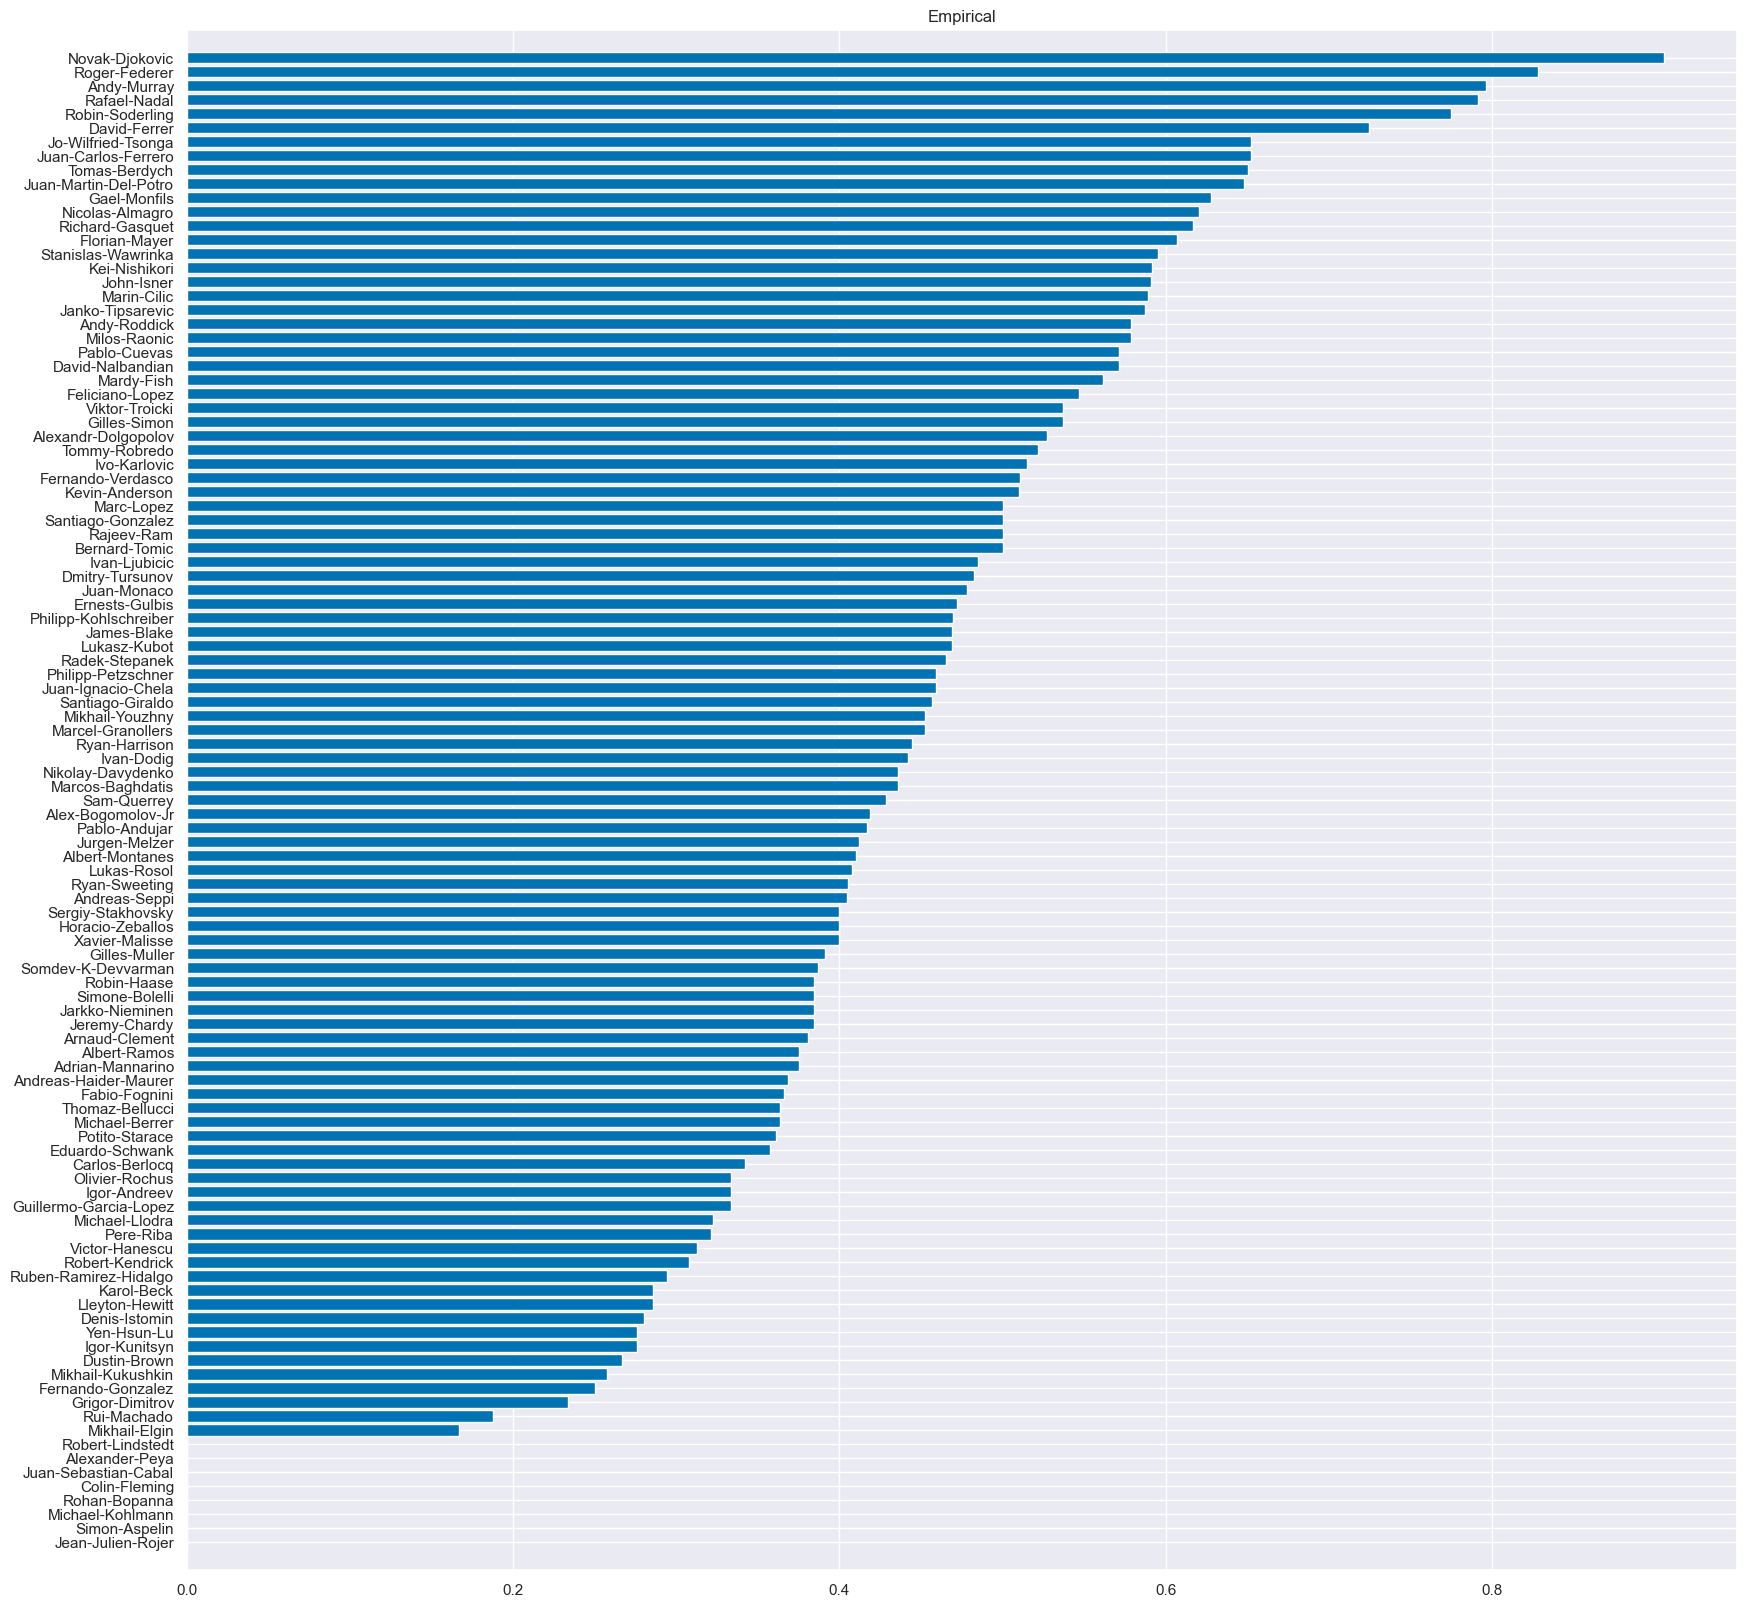

In [28]:
sorted_barplot(empirical_winrate, W, 'Empirical')

In [29]:
emp_sorted_indices = np.argsort(empirical_winrate)
emp_sorted_names = W[emp_sorted_indices]

## 2) predictions based on Gibbs sampling

In [30]:
skill_prob = gibb_direct(W, skill_samples)

In [31]:
Gibbs_winrate = skill_prob.mean(axis=0)

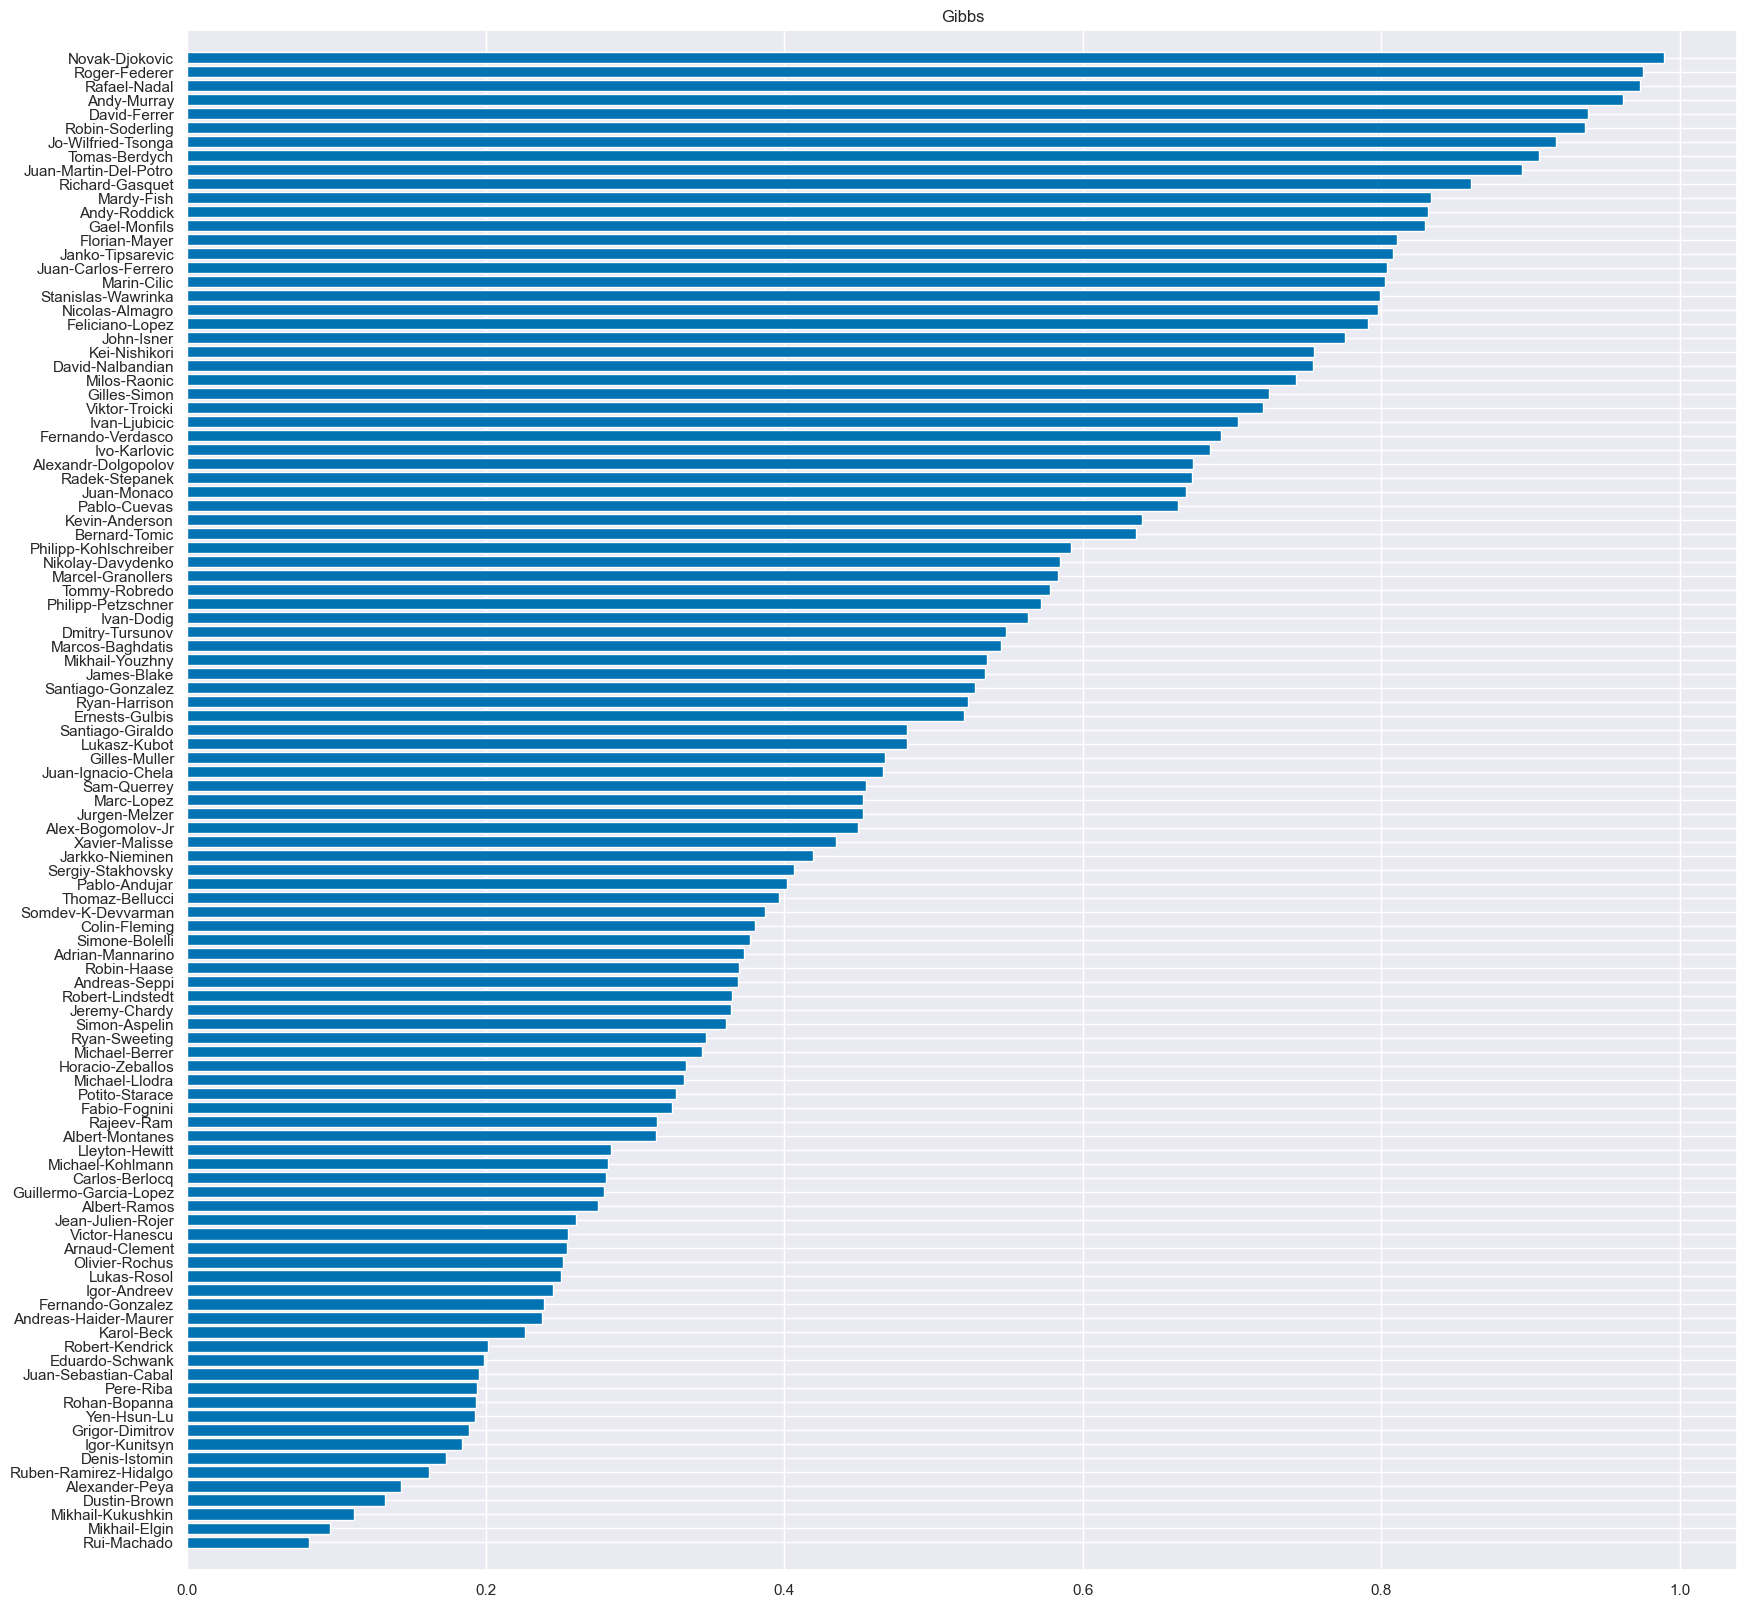

In [32]:
sorted_barplot(Gibbs_winrate, W, 'Gibbs')

In [33]:
Gibb_sorted_indices = np.argsort(Gibbs_winrate)
Gibb_sorted_names = W[Gibb_sorted_indices]

## 3) predictions based on the message passing algorithm

In [34]:
skill_prob, win_prob, names = get_win_skill_prob(mean_player_skills, precision_player_skills, W)

In [35]:
EP_winrate = skill_prob.mean(axis=0)

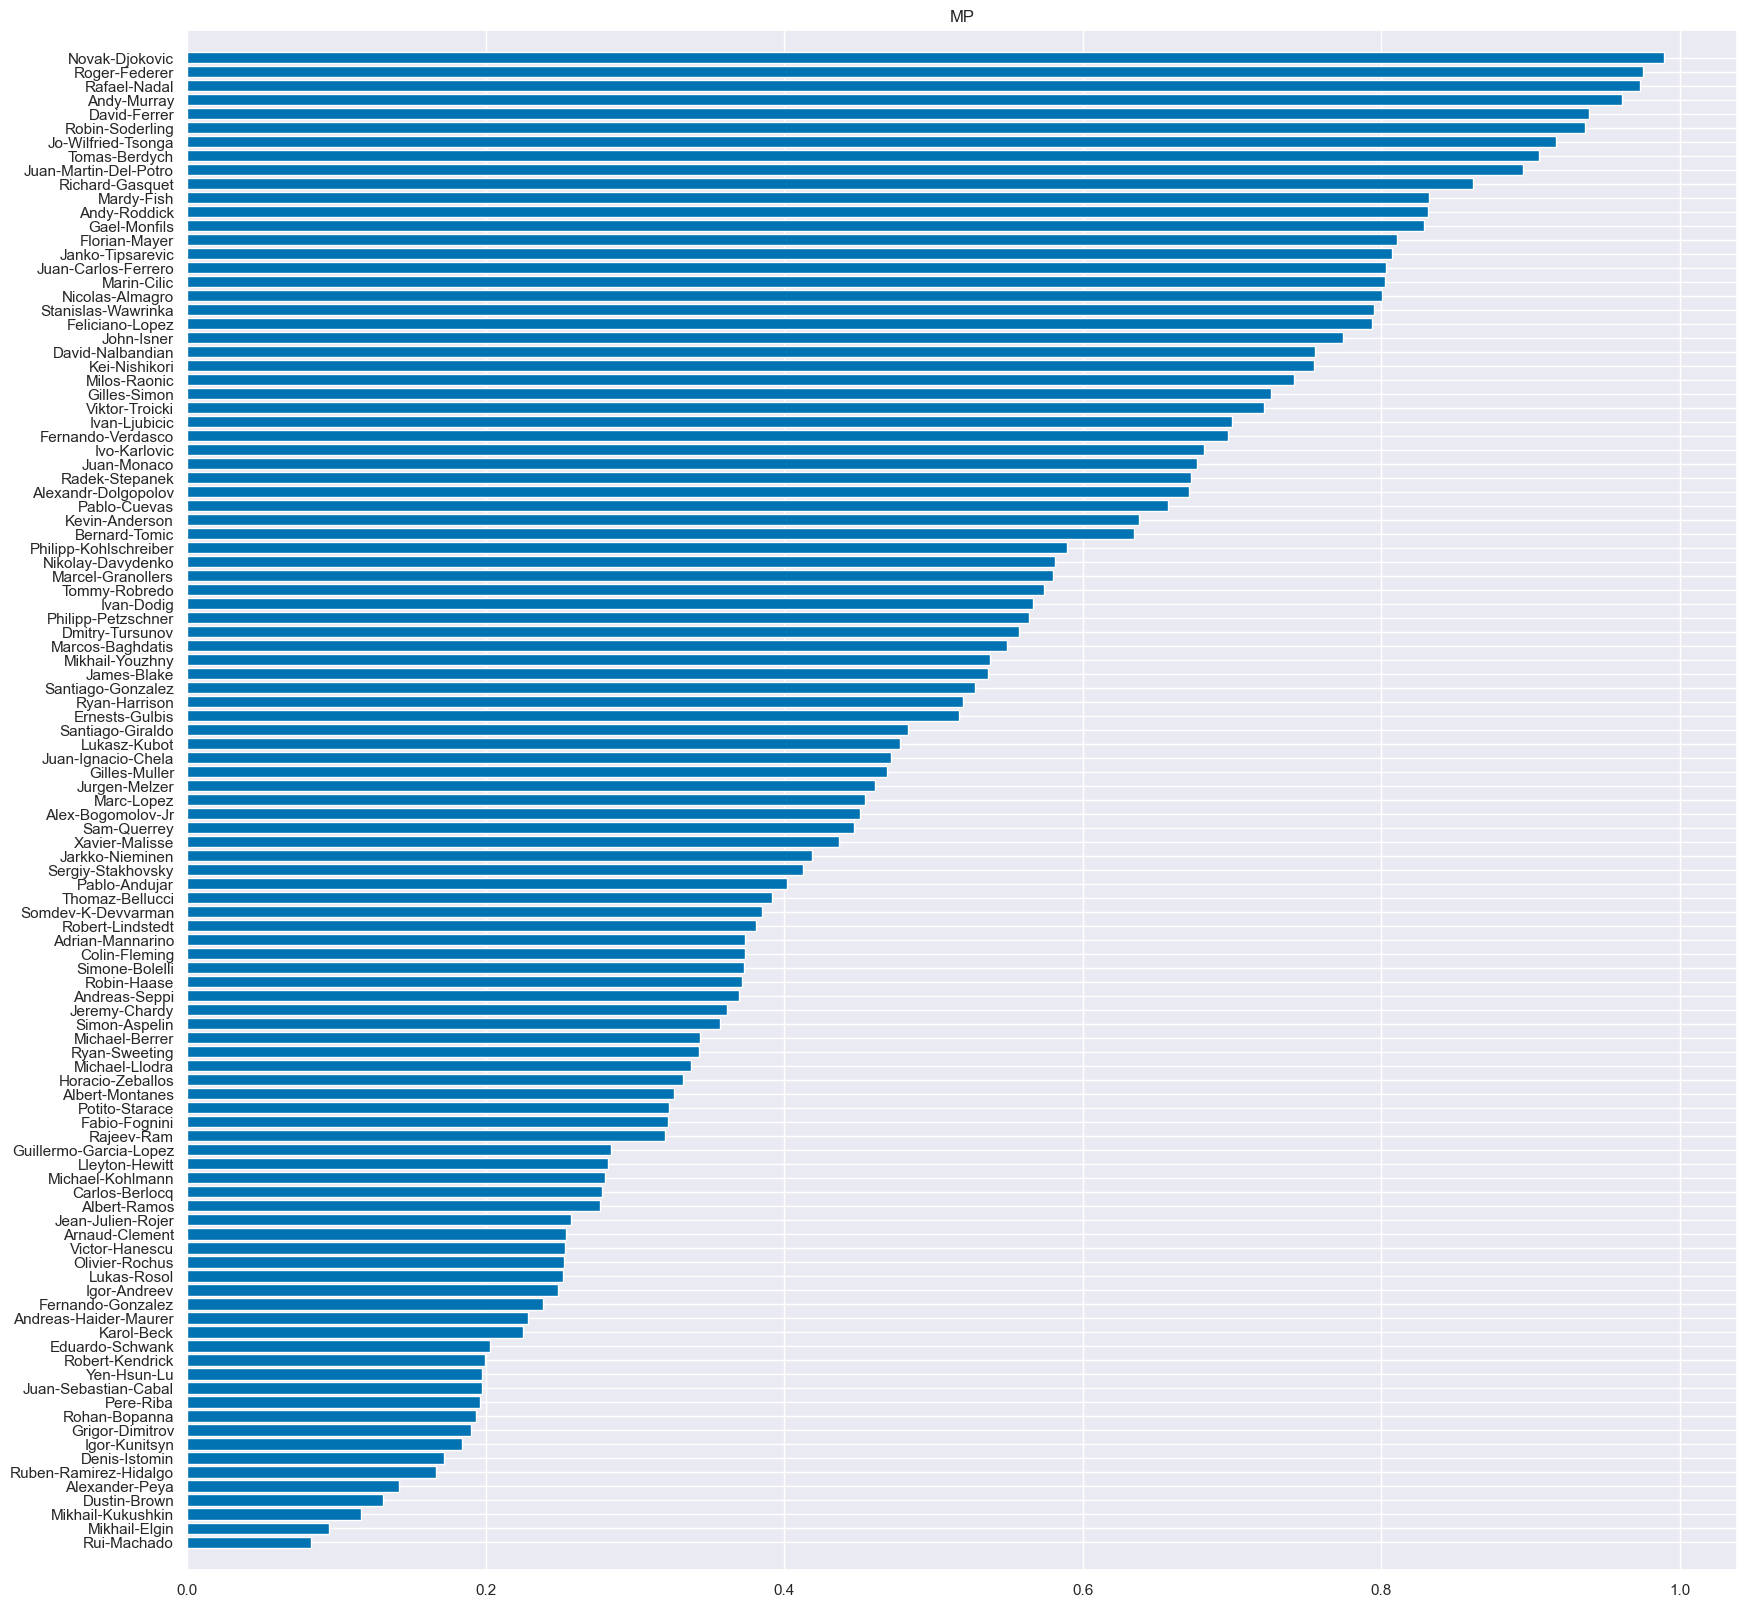

In [36]:
sorted_barplot(EP_winrate, W, 'MP')

In [37]:
EP_sorted_indices = np.argsort(EP_winrate)
EP_sorted_names = W[EP_sorted_indices]

In [38]:
EP_emp_diff = EP_sorted_indices - emp_sorted_indices
Gibbs_emp_diff = Gibb_sorted_indices - emp_sorted_indices
EP_emp_diff

array([-32,   1, -51, -13,  -2, -12, -30, -38, -51,  27,  31,  15,  29,
        -1,  -9, -42,  25,  12,  39,   9, -51,   0,   9,  79,  66, -27,
        66,  20, -52,  22, -40, -16,  47, -35, -33, -54, -10,  11,  62,
        -1,   0,  15,  85, -15,  49, -20,  41,   3, -40, -60,  -1,  42,
         0,  37,  50, -27,  61,  15, -36, -13,  62,  21,   1,  33, -60,
        -4,  -4, -22,  68, -16,  18,  31, -58, -37, -43, -30,   3, -34,
       -34, -16, -19,   0,  17,   5,  19, -45,  12,  10,  -1,  17,   5,
        13,   1,   0,  17, -28, -25,   9, -31, -11,   0,  -6,   6,  10,
       -10,   0,   0], dtype=int64)

In [39]:
EP_correct = np.sum(EP_emp_diff == 0)
Gibbs_correct = np.sum(Gibbs_emp_diff == 0)

print(EP_correct, Gibbs_correct)

8 6


In [40]:
EP_emp_diff_pos = np.sqrt(EP_emp_diff**2)
Gibbs_emp_diff_pos = np.sqrt(Gibbs_emp_diff**2)

In [41]:
EP_correct, Gibbs_correct = [], []
x = []
for i in range(70):
    x.append(i)
    EP_correct.append(np.sum(EP_emp_diff_pos <= i))
    Gibbs_correct.append(np.sum(Gibbs_emp_diff_pos <= i))
print(EP_correct)
print(Gibbs_correct)

[8, 15, 16, 18, 20, 22, 24, 24, 24, 28, 32, 34, 37, 40, 40, 44, 47, 50, 51, 53, 55, 56, 58, 58, 58, 60, 60, 63, 64, 65, 67, 70, 71, 73, 75, 76, 77, 79, 80, 81, 83, 84, 86, 87, 87, 88, 88, 89, 89, 90, 91, 94, 95, 95, 96, 96, 96, 96, 97, 97, 99, 100, 102, 102, 102, 102, 104, 104, 105, 105]
[6, 10, 12, 15, 18, 22, 25, 25, 25, 27, 30, 34, 39, 42, 43, 44, 46, 49, 50, 51, 53, 55, 55, 55, 55, 59, 61, 61, 62, 63, 66, 68, 69, 70, 71, 71, 72, 75, 78, 79, 80, 81, 83, 84, 84, 84, 86, 87, 88, 88, 88, 92, 93, 93, 93, 93, 94, 94, 95, 95, 98, 99, 101, 101, 102, 102, 103, 103, 104, 104]


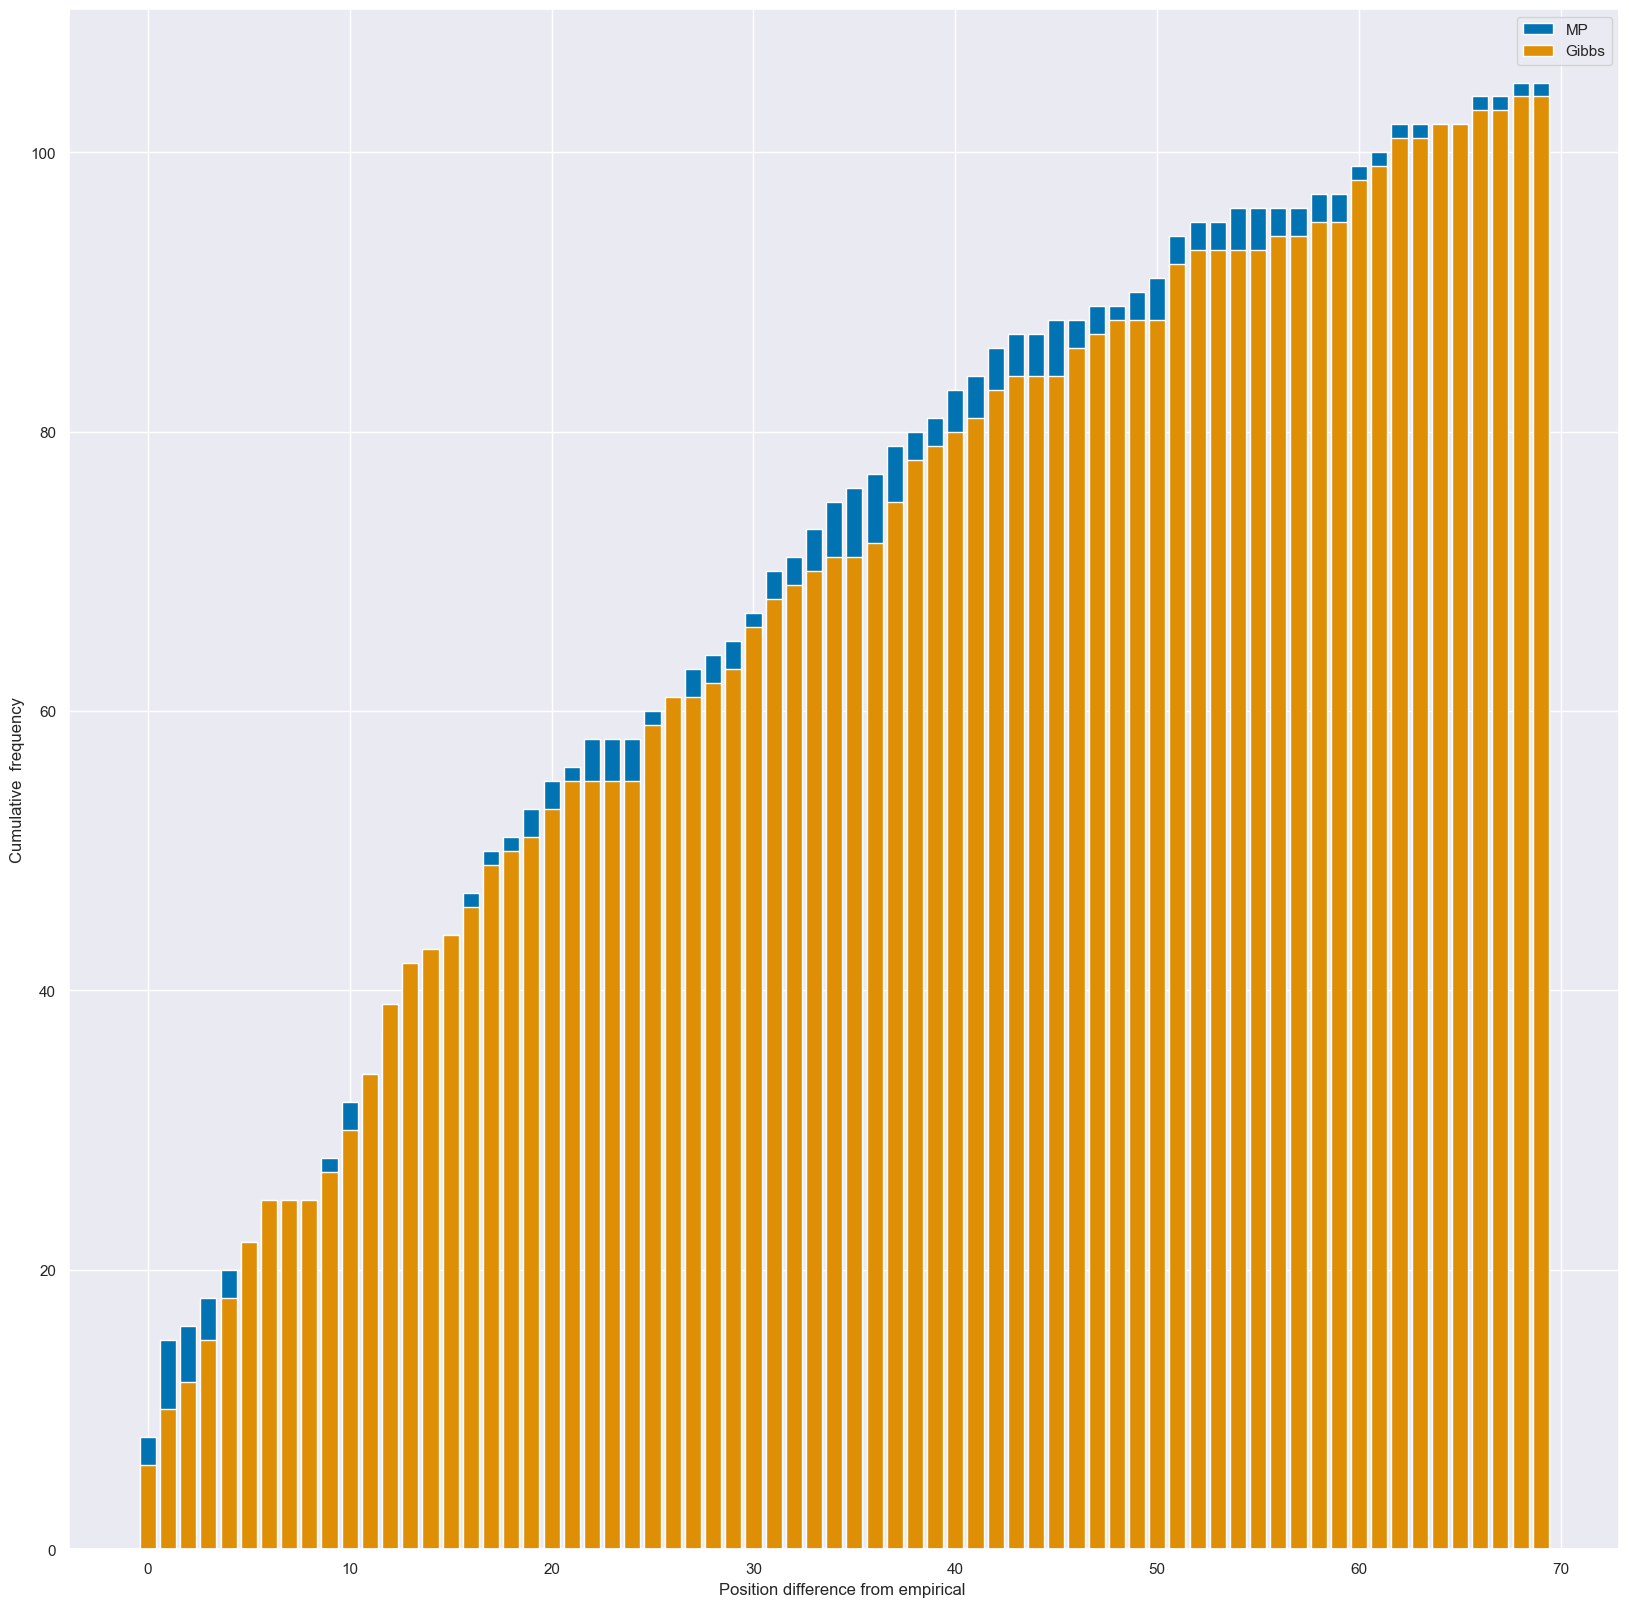

In [42]:
plt.figure(figsize=(20, 20))
plt.bar(x, EP_correct, label="MP")
plt.bar(x, Gibbs_correct, label='Gibbs')
plt.legend()
plt.ylabel('Cumulative  frequency')
plt.xlabel('Position difference from empirical ')
plt.savefig('Figures/Exe_bar.png', format="png", dpi=500, bbox_inches="tight")
plt.show()

KeyboardInterrupt: 

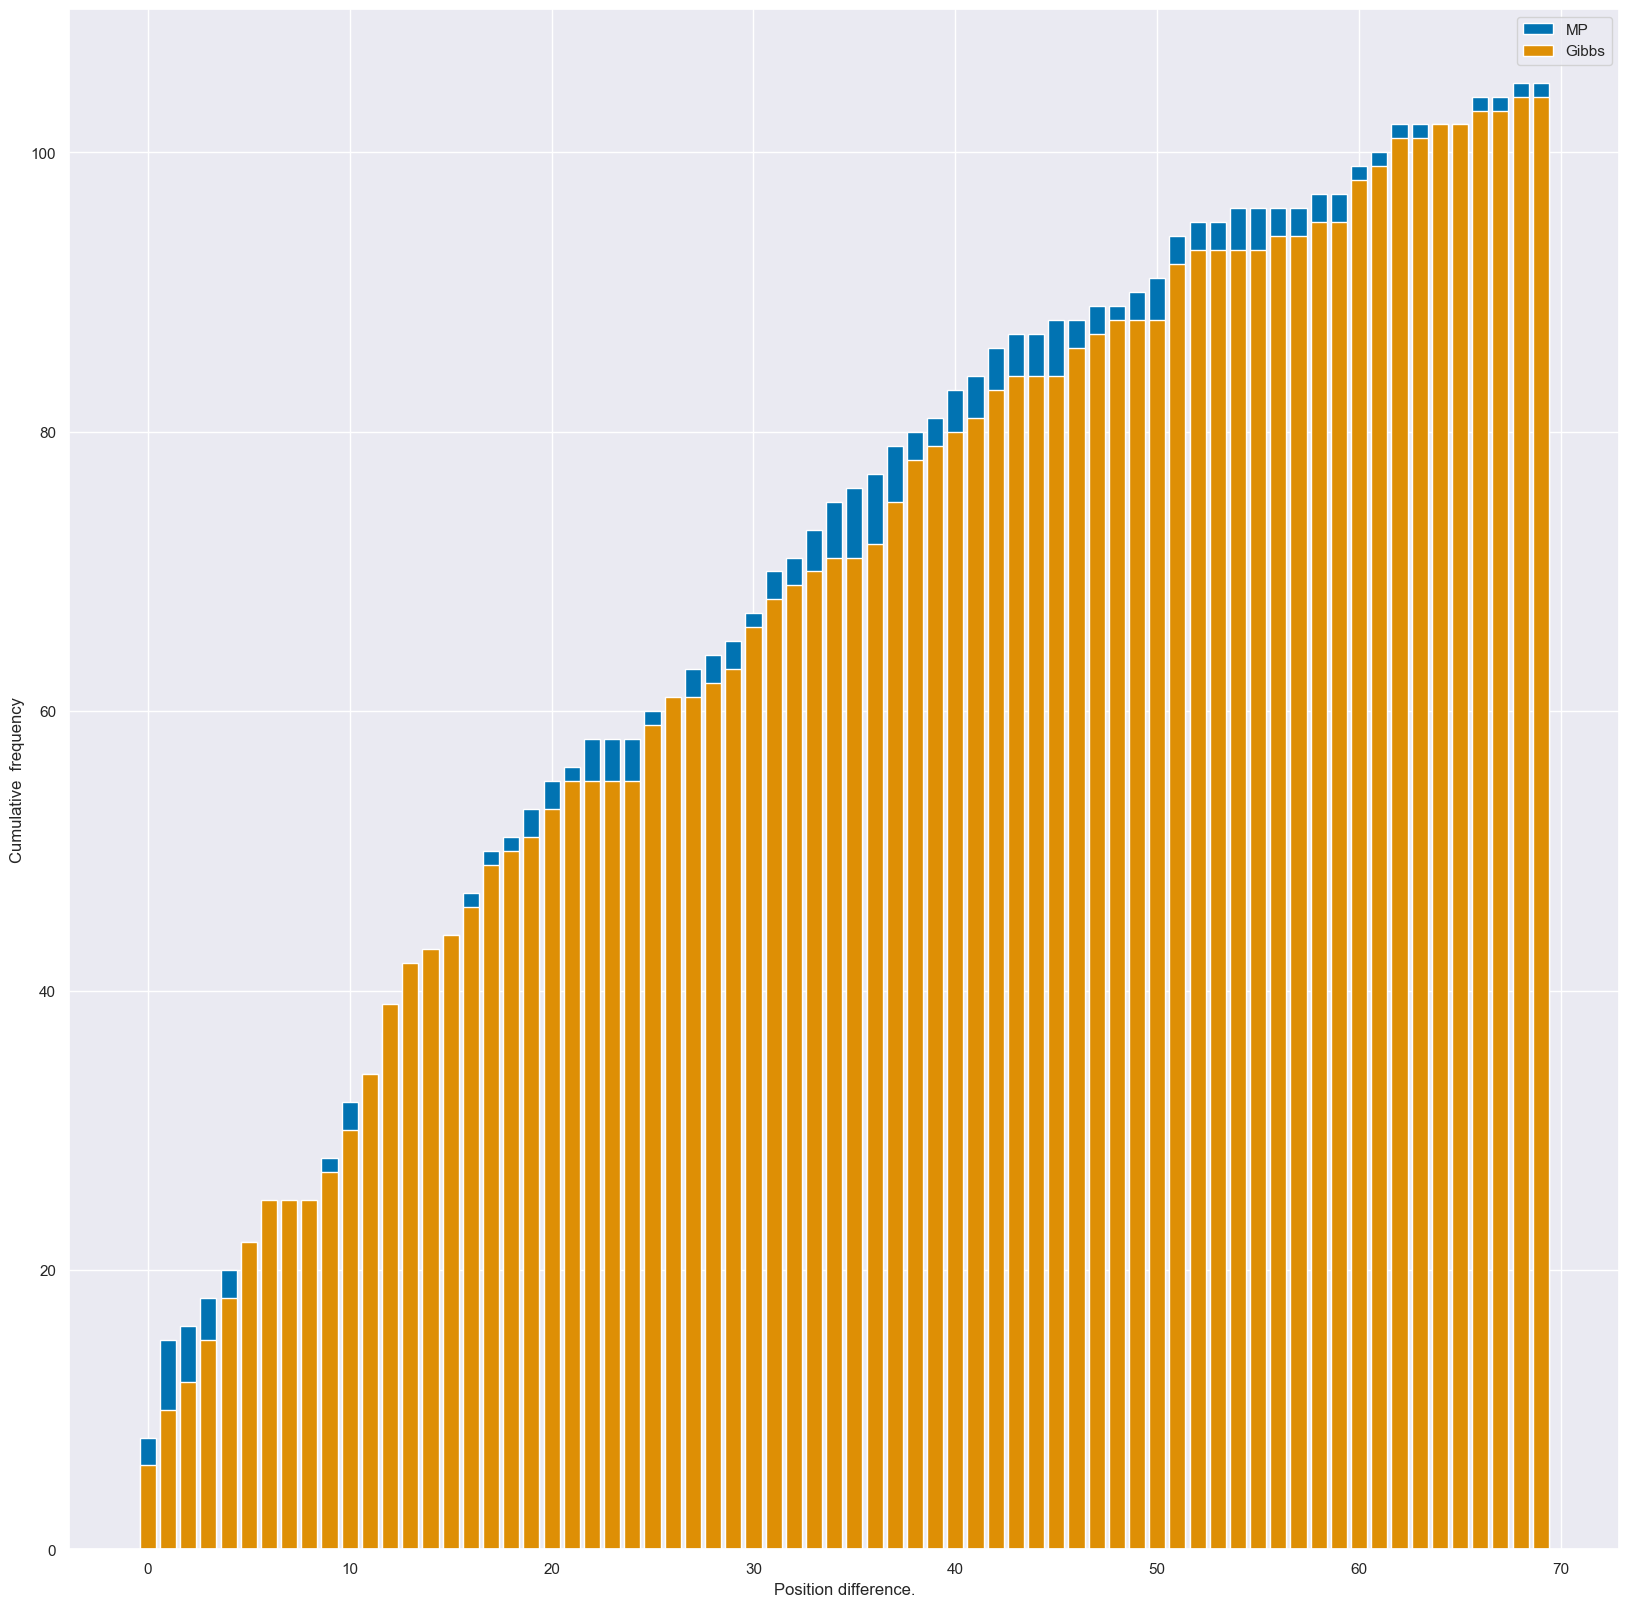

In [43]:
EP_Gibbs_emp_diff = EP_sorted_indices - Gibb_sorted_indices
EP_Gibbs_diff_pos = np.sqrt(EP_Gibbs_emp_diff ** 2)

EP_Gibbs_correct = []
x = []
for i in range(70):
    x.append(i)
    EP_Gibbs_correct.append(np.sum(EP_Gibbs_diff_pos <= i))

plt.figure(figsize=(20, 20))
plt.bar(x, EP_correct, label="MP")
plt.bar(x, Gibbs_correct, label='Gibbs')
plt.legend()
plt.ylabel('Cumulative  frequency')
plt.xlabel('Position difference.')
plt.savefig('Figures/Exe_bar.png', format="png", dpi=500, bbox_inches="tight")
plt.show()